<center>  <h2> Introduction to Probabilistic Graphical Models </h2> </center>

<center> <h3> Practical Session 2 </h3> </center>

#### Different imports that will be needed for this lab :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from numpy.linalg import slogdet
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
matplotlib.style.use('ggplot')
import seaborn

In [2]:
%matplotlib inline

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

------------------------------------------------------------------------------------------------------------------

<h2> <center> EM for GMMs </center> </h2> 

### Table of content : 


[1. Question 1](#1)<br>
[2. Question 2](#2)<br>
[3. Question 3](#3)<br>
[4. Question 3.1](#31)<br>
[5. Question 3.2](#32)<br>
[6. Question 3.2.a](#32a)<br>
[7. Question 3.2.b](#32b)<br>
[8. Question 3.2.c](#32c)<br>
[9. Lab conclusion](#conc)<br>
    

-------------------------------------------------------------------------------------------------

<a id='1'></a>
### Question 1 : 

In Gaussian Mixture Models, we often need to evaluate quantities that are defined as follows : <br> 


$$
\begin{equation} 
\boxed{ \gamma_i(x)=\frac{\pi_i \mathcal{N}(x,\mu_i,\Sigma_i)}{\sum_{j=1}^{K}\pi_j \mathcal{N}(x,\mu_j,\Sigma_j)}}
\end{equation} 
$$




For i $ \in {1 .. k} $, with K, equal to the number of clusters. 

A direct computation of these quantities might be problematic in practice since all the terms $ \pi_i \mathcal{N}(x,\mu_i,\Sigma_i) $  might be very small, and we might end up with 0/0.

Then after replacing the gaussian by it's expression, we get that $\gamma_i(x)$ is equal to : 



$$
\begin{equation} 
\boxed{ \gamma_i(x)=\frac{\pi_i \frac{1}{\sqrt{(2\pi_i)^n}\sqrt{(|\Sigma_i|)}}e^{-\frac{(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)}{2}}}{\sum_{j=1}^{K}\pi_j \frac{1}{\sqrt{(2\pi_j)^n}\sqrt{(|\Sigma_j|)}}e^{-\frac{(x-\mu_j)^T\Sigma_j^{-1}(x-\mu_j)}{2}}}}
\end{equation} 
$$



In [4]:
#log_numerator ------------------------------------------------------------------------------------------
def l_i(x, pi, mu, sigma):
    return np.log(pi) - (0.5 * sigma.shape[0] * np.log(2. * np.pi) + 0.5 * np.linalg.slogdet(sigma)[1] + 0.5 * (x - mu).T.dot(np.linalg.inv(sigma)).dot(x - mu))
#---------------------------------------------------------------------------------------------------------

#The log_gamma function ----------------------------------------------------------------------------------
def log_gamma_k(x, i, pi, mu, sigma):
    K = pi.shape[0]
    return l_i(x, pi[i], mu[i], sigma[i]) - logsumexp([l_i(x, pi[j], mu[j], sigma[j]) for j in range(K)])
#---------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------

<a id='2'></a>
### Question 2:

**Theorothical answer of the question :**

We should maximize the following expression :
$$\log(p(x,z|\pi,\mu,\Sigma^2))=\sum_n \sum_k \mathbb{1}_{z_n=k}log(\pi_k \mathcal{N}(x_n|\mu_k,\Sigma_k)) $$ 
$$   with : \sum_{k=1}^K\pi_k=1$$  


We do as the following :

We have $$p(x_{1:N},z_{1:N}|\mu_{1:K},\Sigma_{1:k},\pi_{1:K})=\Pi_n^{N}\Pi_k^{K}(\pi_k \mathcal{N}(x,\mu_k,\Sigma_k))^\mathbb{1_{z_n=k}}$$
and so,  $$\log(p(x_{1:N},z_{1:N}|\mu_{1:K},\Sigma_{1:k},\pi_{1:K})) = \sum_n^{N} \sum_k^{K} \mathbb{1_{z_n=k}}( \log(\pi_k)+\log(\mathcal{N}(x,\mu_k,\Sigma_k))$$

------------------------------------------------------------------------------------------------------------------

So, what we need to do, is that we need to compute the expectation of the indicator function $\mathbb{1_{z_n=k}}$ with respect to $p(z|x,\pi,\mu,\Sigma^2)$ , and we get :

$\begin{align*} 
L(\mu_{1:K},\Sigma_{1:k},\pi_{1:K}))&=\mathbb{E}_{p(z|x_{1:n},\mu_{1:K},\Sigma_{1:k},\pi_{1:K})}(\log(p(x_{1:N},z_{1:N}|\mu_{1:K},\Sigma_{1:k},\pi_{1:K}))) \\ 
&= \sum_n^{N} \sum_k^{K} \mathbb{E}(\mathbb{1_{z_n=k}})( \log(\pi_k)+\log(\mathcal{N}(x,\mu_k,\Sigma_k))\\
&= \sum_n^{N} \sum_k^{K} \gamma_k(x)( \log(\pi_k)+\log(\mathcal{N}(x,\mu_k,\Sigma_k))\\
\end{align*}$


$$
\begin{equation} 
\boxed{ \mathbb{E}_{p(z|x_{1:n},\mu_{1:K},\Sigma_{1:k},\pi_{1:K})}(\mathbb{1_{z_n=k}})=\frac{\pi_i \mathcal{N}(x,\mu_i,\Sigma_i)}{\sum_{j=1}^{K}\pi_j \mathcal{N}(x,\mu_j,\Sigma_j)}=\gamma_k(x) }
\end{equation} 
$$


we have 

$$(\mu_{1:K},\Sigma_{1:k},\pi_{1:K})^*=\arg\max_{(\mu_{1:K},\Sigma_{1:k},\pi_{1:K})}L(\mu_{1:K},\Sigma_{1:k},\pi_{1:K}))$$




-----------------------------------------------------------------------------------------------------------------

What we need to do later, is that we need to compute the lagrangian and try to maximize the expression :

We need to find the $\lambda$ : 


$$argmax_{\pi_k}{\sum_n\sum_k\mathbb{1_{z_n=k}}\log(\pi_k)+\log(\mathcal{N(x_n,\mu_k,\Sigma_k)}-\lambda(\sum_k\pi_k-1)}=argmax_{\pi_k}{\sum_n\sum_k\mathbb{1_{z_n=k}}\log(\pi_k)+\lambda(\sum_k\pi_k-1)}$$

Let : 

$$g_1(x)=\sum_n^{N} \sum_k^{K} \mathbb{1_{z_n=k}}\log(\Pi_k)-\lambda (\sum_k^{K}\Pi_k-1)$$
$\triangledown g_1(x)=0 $ ,  which means that,  $ \lambda=\sum_n^{N} \sum_k^{K}\mathbb{1_{z_n=k}}=N$
and then we get: 



$$
\begin{equation} 
\boxed{ \Pi_{k}^* = \frac{ \sum_n^{N}\mathbb{1_{z_n=k}} } { N } }
\end{equation} 
$$

------------------------------------------------------------------------------------------------------------------

Then, we should find $\mu_k$ :

We will do it as follow :

$\begin{align*} 
\triangledown_{\mu_k}\log(p(x,z|\mu_{1:K},\Sigma_{1:k},\pi_{1:K})&=\sum_n^{N} \mathbb{1_{z_n=k}}\triangledown_{\mu_k}\log(p(x_n|\mu_{K},\Sigma_{k})\\ 
&=-\sum_n^{N} \mathbb{1_{z_n=k}}\frac{x_n-u_k}{\sigma^2}\\
&=0
\end{align*}$
then $$\mu_{k}=\sum_n^{N} \mathbb{1_{z_n=k}}\frac{x_n}{\sum_i^{N} \mathbb{1_{z_{i}=k}}}$$

We pass the expectation over $u_k$, we obtain :

$$
\begin{equation} 
\boxed{ \mu_{k}^* =  \frac{\sum_n^{N} \gamma_k^t(x_n) x_n} {\sum_i^{N} \gamma_k^t(x_n)} }
\end{equation} 
$$

---------------------------------------------------------------------------------------------------------------

And now, we just need to find  $\sigma_k$ :


To do so, we just need derive the first expression with $\Sigma_k$:


$$ \sum_n\mathbb{1_{z_n=k}}(-\frac{1}{2}\Sigma_k^{-1}+\frac{1}{2}\Sigma_k^{-1}(x_n-\mu_k)(x_n-\mu_k)^T\Sigma_k^{-1})=0 $$

and so, we get :

$$ \sum_n\mathbb{1_{z_n=k}}(-\frac{1}{2}I+\frac{1}{2}(x_n-\mu_k)(x_n-\mu_k)^T\Sigma_k^{-1})=0 $$

And then, we just need to multiply by $\Sigma_k$ and we get : 

$$ \sum_n\mathbb{1_{z_n=k}}(-\frac{1}{2}\Sigma_k+\frac{1}{2}(x_n-\mu_k)(x_n-\mu_k)^T)=0 $$

$$ \sum_n\mathbb{1_{z_n=k}}(\frac{1}{2}\Sigma_k-\frac{1}{2}(x_n-\mu_k)(x_n-\mu_k)^T)=0 $$

$$ \sum_n\mathbb{1_{z_n=k}}(\Sigma_k-(x_n-\mu_k)(x_n-\mu_k)^T)=0 $$

And then finnaly, we get our expression :

$$
\begin{equation} 
\boxed{ \Sigma_k^* =\frac{\sum_n\mathbb{1_{z_n=k}}(x_n-\mu_k)(x_n-\mu_k)^T}{\sum_n\mathbb{1_{z_n=k}}} }
\end{equation} 
$$


------------------------------------------------------------------------------------------------------------------

**NB : We will define two plot functions, that will be so useful to vizualize the different clustering steps of the algorithm for question 3.**

The M-step is defined inside the EM-algorithm function that is defined below : [Click here to see it.](#m-step)<br>

In [5]:
#This function was found on the internet. 
def ellipse_plot(A, mu=np.array([0,0]), col='b'):
    '''
    Creates an ellipse from short line segments y = A x + \mu 
    where x is on the unit circle.
    '''
    ## This function will be used in the third question to find th contour of the clusters.
    
    N = 36
    th = np.arange(0, 2*np.pi+np.pi/N, np.pi/N)
    X = np.array([np.cos(th),np.sin(th)])

    Y = np.dot(A, X)
    ln = plt.Line2D(mu[0]+Y[0,:],mu[1]+Y[1,:],markeredgecolor='k', linewidth=1, color=col)
    return ln

In [6]:
def plot_distribution(X, mu, sigma, cluster_probability, t, plot_iteration, nb_iteration):
    """
    Input:
    X : data point
    mu : mean vector
    sigma : vector of  K matrices of variance
    cluster_probability : vetor of corresponding cluster for points X
    t: number of iteration
    plot_iteration : plot figure for each plot_each
    
    
    Output: Some plot figures
    """
    if (t % plot_iteration == 0):
        
        
        fig = plt.figure(figsize=(15,7))
        ax0 = fig.add_subplot(111)
        ax0.scatter( X[:,0], X[:,1], c = cluster_probability)
        ax0.set_title('Point distribution at iteration :' + str(t))
    
        colors = ['blueviolet', 'darkturquoise', 'y']
        ax = plt.gca()
        
        for i in range(3):
            A = np.linalg.cholesky(sigma[i])
            m = mu[i]

            plt.scatter(m[0], m[1], marker = '4', c = colors[i], s = 500)
            ln = ellipse_plot(3*A, m, colors[i])
            ax.add_line(ln)

<a id='m-step'></a>

In [7]:
def EM_algorithm(X, pi0, mu0, sigma0, plot_iteration, nb_iteration = 1):   
    
    """
    Input:
    X : data point matrix
    pi0 : Known pi
    mu0 : Known mu
    sigma0 : Known sigma
    nb_iteration : Number of algorithm iterations
    
    Output: pi, mu, sigma and the log_likelihood
    """  
#Different intializations :
    pi = pi0
    mu = mu0
    sigma = sigma0
    N = X.shape[0]
    log_likelihood = np.array([])


## M-step - As explained theorically in question 2
## ---------------------------------------------------------------------------------------------------------
## ---------------------------------------------------------------------------------------------------------

    for t in range(nb_iteration):

        array_pi = []
        array_mu = []
        array_sigma = []
        
    
        for k in range(K):
            
            ## Gamma: -----------------------------------------------------------------------        
            gamma_k = np.exp([log_gamma_k(X[n],k,pi,mu, sigma) for n in range(N)])
            ## ------------------------------------------------------------------------------
            ## For each cluster, we need to compute a Gamma_k.
            ## Gamma_k is a vector of size N. 
            
            
            ## Mu_k: ------------------------------------------------------------------------
            mu_k = np.sum(np.array([gamma_k[n] * X[n] for n in range(N)]), axis = 0) / np.sum(gamma_k)
            ## Mu_k is also a vector of size N. 
            ## X[n] is a vector of size N, and that is why we used axis = 0
            
            ## Sigma_k: ----------------------------------------------------------------------
            sigma_k = np.sum(np.array([gamma_k[n] * (X[n] - mu_k).reshape((mu_k.shape[0],1)).dot((X[n] - mu_k).reshape((mu_k.shape[0],1)).T) for n in range(N)]),
                             axis = 0) / np.sum(gamma_k)
            
            ## Pi_k: ------------------------------------------------------------------------
            pi_k = np.sum(gamma_k) / N       
            ## --------------------------------------------------------------------------------
            
            #For every cluster :
            ## --------------------------------------------------------------------------------
            array_pi.append(pi_k)
            array_mu.append(mu_k)
            array_sigma.append(sigma_k)                   
            ## --------------------------------------------------------------------------------
            
            
        pi = np.array(array_pi)
        mu = np.array(array_mu)
        sigma = np.array(array_sigma)
        
## ---------------------------------------------------------------------------------------------------------
## --------------------------------------------------------------------------------------------------------- 

        
        ## Cluster prediction ---------------------------------------
        cluster_prob = np.array([])
        for i in range(N):
            
            temp = np.array([])
    
            for j in range(K):
                temp = np.append( temp , np.exp(l_i(X[i,:], pi[j], mu[j], sigma[j]) ) / pi[j] )
            
            cluster_prob = np.append(cluster_prob,np.argmax(temp))
        ## -------------------------------------------------------------------------------------
        
       
        ## Loglikelihood computation ------------------------------------------------------------------------------------
        log_likelihood_t = np.array([logsumexp([l_i(X[n], array_pi[i], array_mu[i], array_sigma[i]) for i in range(K)]) for n in range(N)])
        log_likelihood = np.append(log_likelihood, np.sum(log_likelihood_t))
        ## -----------------------------------------------------------------------------------------------------------------------
        
        ## We will use the plot function defined above :----------------------------------
        plot_distribution(X, mu, sigma, cluster_prob, t, plot_iteration, nb_iteration) 
        ## --------------------------------------------------------------------------------------------------------
    
    return pi, mu, sigma, log_likelihood

-------------------------------------------------------------------------------------------------

<a id='3'></a>
### Question 3 :

**3.0 - Different initializations :**

 Initialisation of  $\pi_{1:K}^{(0)}$ , $\mu_{1:K}^{(0)}$ and  $\Sigma_{1:K}^{(0)}$ and K

In [8]:
#Different intializations 
K = 3
pi0 = np.array([0.3, 0.2, 0.5])
mu0 = np.array([[0,0],[1,2],[2,0]])
sigma0 = np.array([[[1.00, -0.25], [ -0.25, 0.50]],
                  [ [0.50, 0.25],[0.25, 0.50]], 
                  [[0.50, -0.25], [-0.25, 1]]])

-------------------------------------------------------------------------------------------------

<a id='31'></a>
**3.1 - Dataset generation :**

In [9]:
#Like defined in the course, at the introduction of the GMMs :
# N = 1000 like asked in question 3.
def X_generation(K, pi, mu, sigma, N = 1000):
    X = np.array([np.random.multivariate_normal(mu[k],sigma[k],N)*pi[k] for k in range(K)])
    X = np.sum(X,axis=0)
    return X

In [10]:
X_data = X_generation(K, pi0, mu0, sigma0)

We will now vizualize the distribution we just made, using the model definition of question 3.

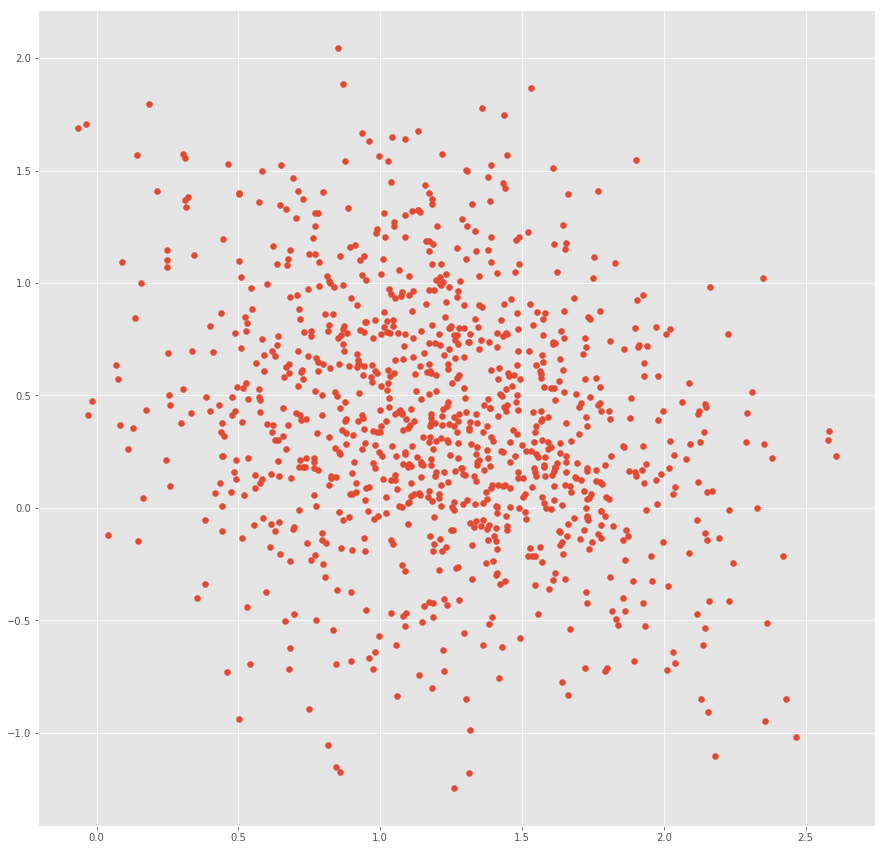

In [11]:
plt.figure(figsize=(15,15))
plt.scatter(X_data[:,0],X_data[:,1])

-------------------------------------------------------------------------------------------------

<a id='32a'></a>
**3.2- a Implementation of the GMMs algorithm :** 

We will compute a random initialization function :

In [12]:
def random_generation(K=3,d=2):
    p_=np.random.rand(K)
    u_=np.random.rand(K,d)*4
    A = np.random.rand(K,d,d)
    return p_ / np.sum(p_) , u_ , np.array([A[i,:,:].dot(A[i,:,:].T) for i in range(K)])

In [13]:
pi_init_random, mu_init_random, sigma_init_random = random_generation()

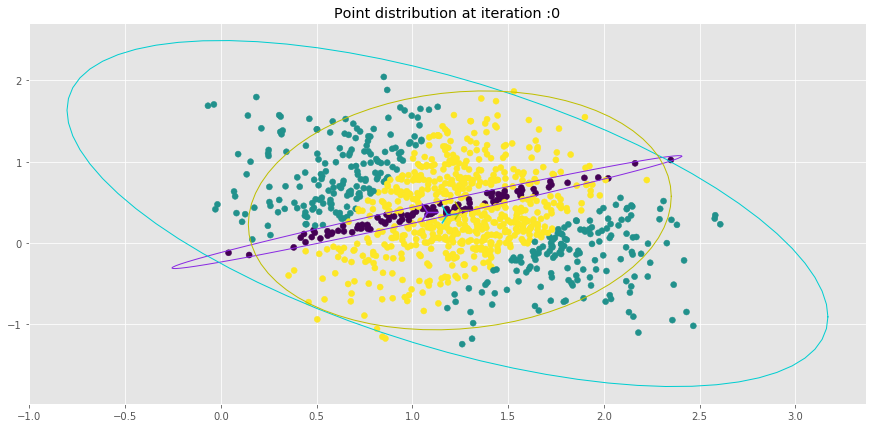

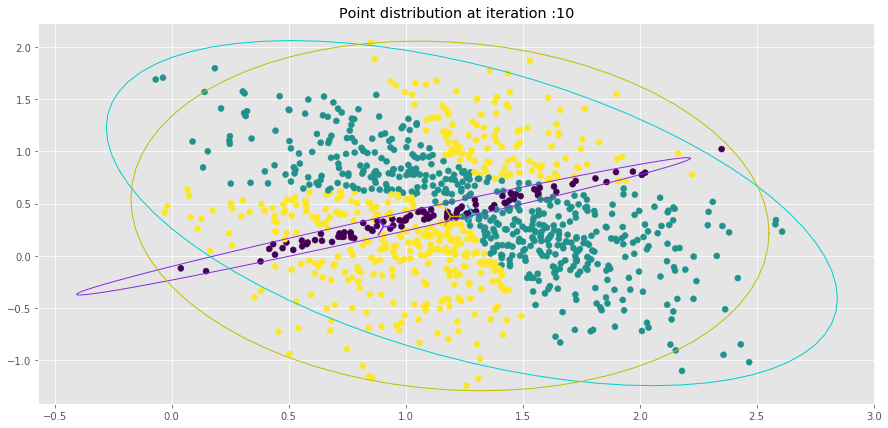

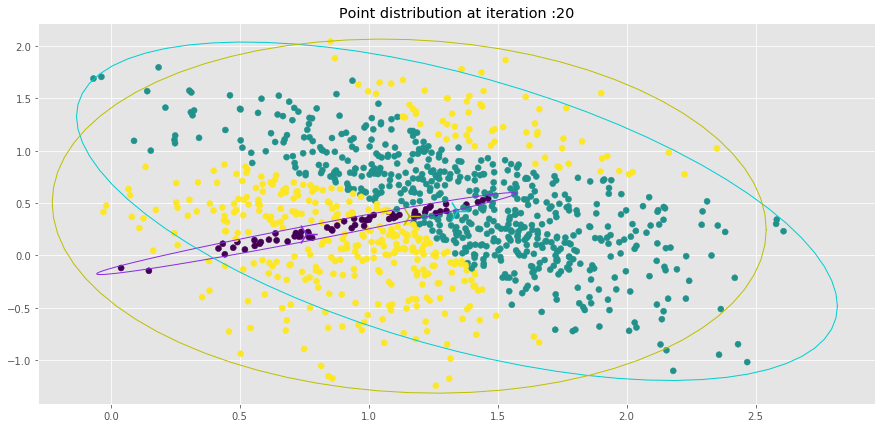

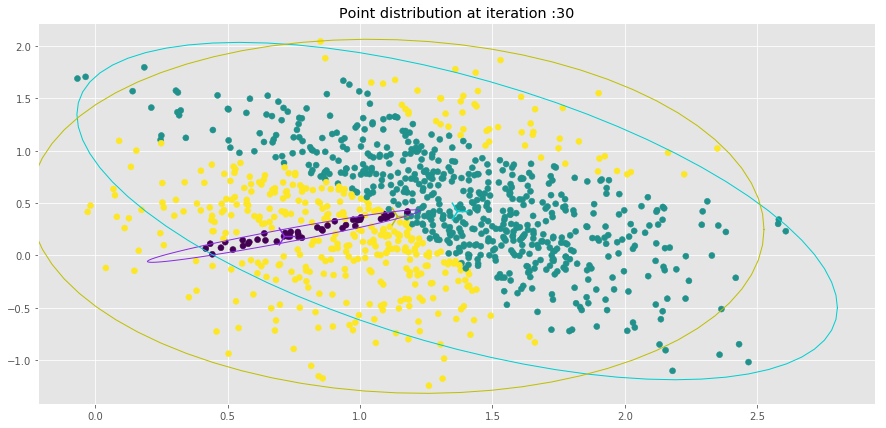

In [14]:
pi_final_random, mu_final_random, sigma_final_random, log_likelihood_final_random = EM_algorithm(X_data, pi_init_random, mu_init_random, sigma_init_random, plot_iteration = 10 , nb_iteration = 40)

-------------------------------------------------------------------------------------------------

<a id='32b'></a>
**3.2 - b : While running the EM algorithm, compute the log-likelihood.  Plot the log-likelihood vs iterations.**

For this purpose, we will define a function that will be usefull to plot to log-likelihood. 

In [15]:
def plot_log_likelihood(log_likelihood):
    plt.figure(figsize=(15,7))
    plt.plot(log_likelihood)
    plt.title("The log likelihood graph")
    plt.xlabel("Iterations")
    plt.ylabel("Log likelihood")

We will now compute the log likelihood of the EM algorithm, using the random parameters of the previous question.

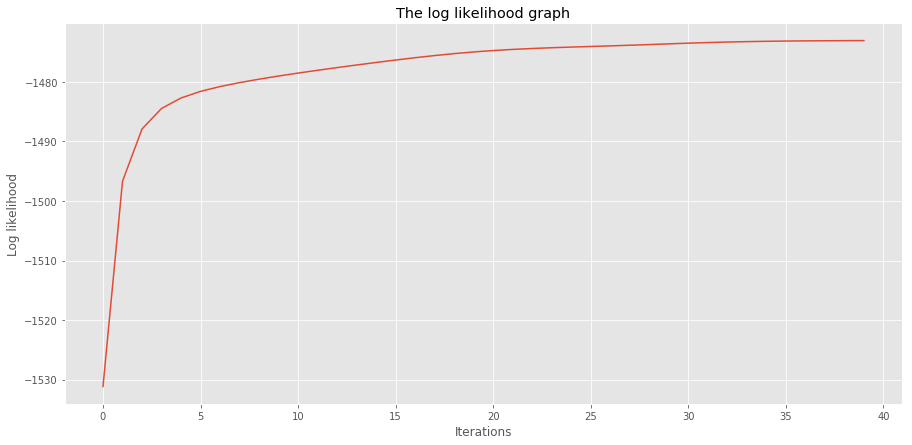

In [16]:
plot_log_likelihood(log_likelihood_final_random)

-------------------------------------------------------------------------------------------------

<a id='32c'></a>
**3.2 - c : Run the EM algorithm with different initializations for pi0, mu0 and sigma0.  How sensitive is the algorithm for different initial values?**

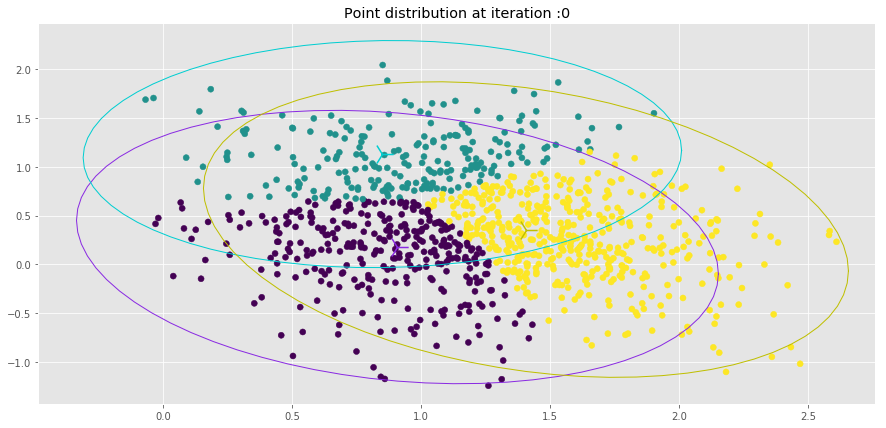

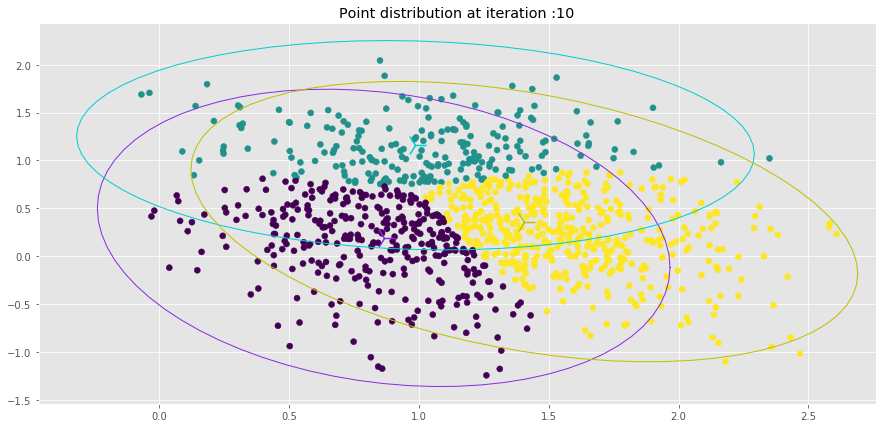

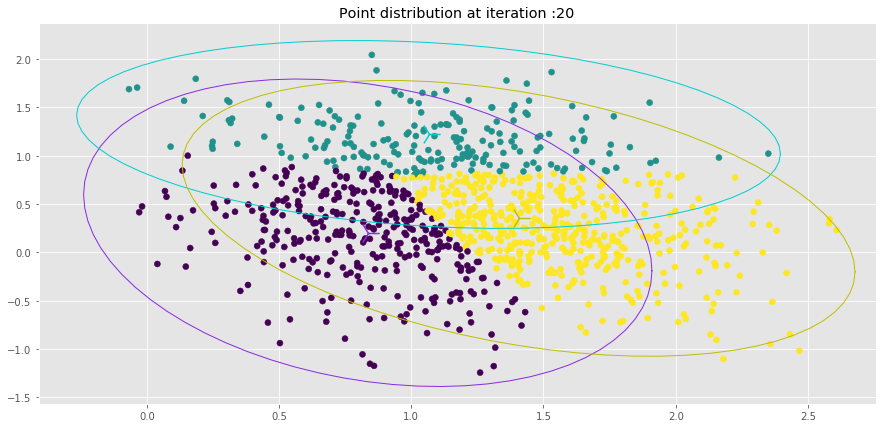

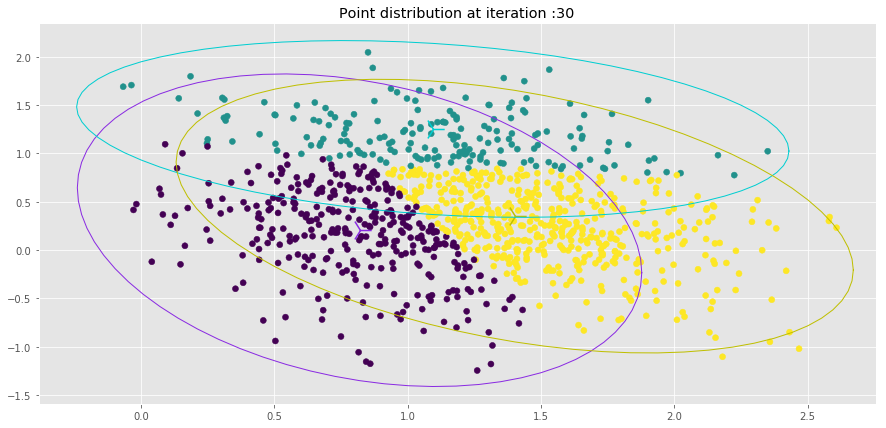

In [17]:
pi_final, mu_final, sigma_final, log_likelihood_final = EM_algorithm(X_data, pi0, mu0, sigma0, plot_iteration = 10 , nb_iteration = 40)

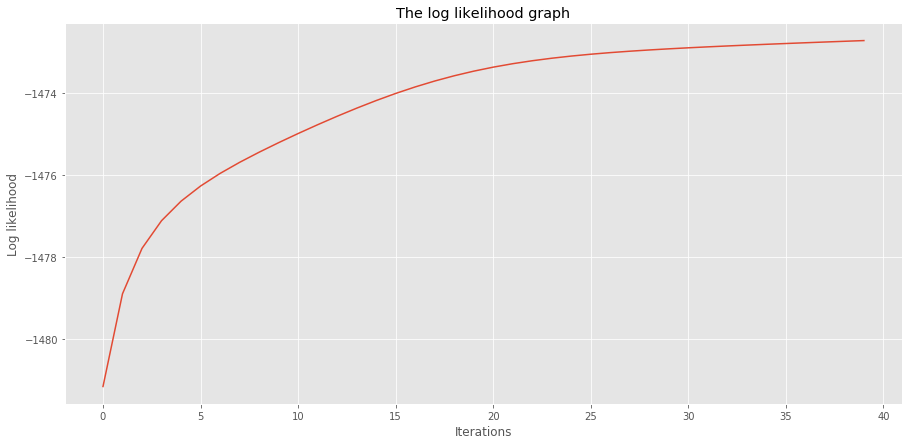

In [18]:
plot_log_likelihood(log_likelihood_final)

-------------------------------------------------------------------------------------------------

<a id='conc'></a>
### Lab conclusion :

When we compare the distribution of points in the clusters, that we got in the question 3.2, where we randomly initiliazed the parameters $\pi_{1:K}$ , $\mu_{1:K}$ and  $\Sigma_{1:K}$ , and in the last question where we used the true parameters. <br>

We see that the is a difference in the points distribution between clusters. That means that the algorithm is very sensitive to the intial values of  $\pi_{1:K}$ , $\mu_{1:K}$ and  $\Sigma_{1:K}$ .

-------------------------------------------------------------------------------------------------

We will now compare the different log likelihood graphs :

Text(0, 0.5, 'Log likelihood value')

<Figure size 432x288 with 0 Axes>

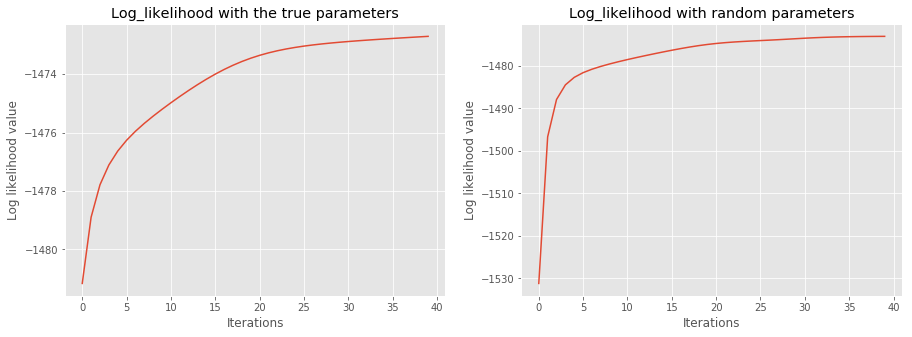

In [19]:
fig = plt.figure()

f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(log_likelihood_final)
ax2.plot(log_likelihood_final_random)

ax1.set_title("Log_likelihood with the true parameters")
ax2.set_title("Log_likelihood with random parameters")

ax1.set_xlabel("Iterations")
ax2.set_xlabel("Iterations")

ax1.set_ylabel("Log likelihood value")
ax2.set_ylabel("Log likelihood value")

We see here also, that with different intializations parameters, we get different log likelihood graphs. It confirms what we said earlier about the big influence that the intializations have on this algorithm.